### Cora dataset(数据集描述：[Yang et al. (2016)](https://arxiv.org/abs/1603.08861))
- 论文引用数据集，每一个点有1433维向量
- 最终要对每个点进行7分类任务(每个类别只有20个点有标注)

In [3]:
from torch_geometric.datasets import Planetoid  # 下载数据集用的
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora',
                    transform=NormalizeFeatures())  # transform预处理

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(
    f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


- val_mask和test_mask分别表示这个点需要被用到哪个集中

In [4]:
# 可视化部分
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

### 试试直接用传统的全连接层会咋样(Multi-layer Perception Network)

In [6]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from tqdm import tqdm


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x


model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [9]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
# Define optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x)  # Perform a single forward pass.
    # Compute the loss solely based on the training nodes.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    # Check against ground-truth labels.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    # Derive ratio of correct predictions.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc


for epoch in tqdm(range(1, 201)):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

  0%|          | 0/200 [00:00<?, ?it/s]

 15%|█▌        | 30/200 [00:00<00:00, 297.03it/s]

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


 56%|█████▋    | 113/200 [00:00<00:00, 384.51it/s]

Epoch: 071, Loss: 0.7094
Epoch: 072, Loss: 0.7238
Epoch: 073, Loss: 0.7150
Epoch: 074, Loss: 0.6191
Epoch: 075, Loss: 0.6770
Epoch: 076, Loss: 0.6487
Epoch: 077, Loss: 0.6258
Epoch: 078, Loss: 0.5821
Epoch: 079, Loss: 0.5637
Epoch: 080, Loss: 0.6368
Epoch: 081, Loss: 0.6333
Epoch: 082, Loss: 0.6434
Epoch: 083, Loss: 0.5974
Epoch: 084, Loss: 0.6176
Epoch: 085, Loss: 0.5972
Epoch: 086, Loss: 0.4690
Epoch: 087, Loss: 0.6362
Epoch: 088, Loss: 0.6118
Epoch: 089, Loss: 0.5248
Epoch: 090, Loss: 0.5520
Epoch: 091, Loss: 0.6130
Epoch: 092, Loss: 0.5361
Epoch: 093, Loss: 0.5594
Epoch: 094, Loss: 0.5049
Epoch: 095, Loss: 0.5043
Epoch: 096, Loss: 0.5235
Epoch: 097, Loss: 0.5451
Epoch: 098, Loss: 0.5329
Epoch: 099, Loss: 0.5008
Epoch: 100, Loss: 0.5350
Epoch: 101, Loss: 0.5343
Epoch: 102, Loss: 0.5138
Epoch: 103, Loss: 0.5377
Epoch: 104, Loss: 0.5353
Epoch: 105, Loss: 0.5176
Epoch: 106, Loss: 0.5229
Epoch: 107, Loss: 0.4558
Epoch: 108, Loss: 0.4883
Epoch: 109, Loss: 0.4659
Epoch: 110, Loss: 0.4908


100%|██████████| 200/200 [00:00<00:00, 383.18it/s]

Epoch: 159, Loss: 0.4066
Epoch: 160, Loss: 0.3782
Epoch: 161, Loss: 0.3836
Epoch: 162, Loss: 0.4172
Epoch: 163, Loss: 0.3993
Epoch: 164, Loss: 0.4477
Epoch: 165, Loss: 0.3714
Epoch: 166, Loss: 0.3610
Epoch: 167, Loss: 0.4546
Epoch: 168, Loss: 0.4387
Epoch: 169, Loss: 0.3793
Epoch: 170, Loss: 0.3704
Epoch: 171, Loss: 0.4286
Epoch: 172, Loss: 0.4131
Epoch: 173, Loss: 0.3795
Epoch: 174, Loss: 0.4230
Epoch: 175, Loss: 0.4139
Epoch: 176, Loss: 0.3586
Epoch: 177, Loss: 0.3588
Epoch: 178, Loss: 0.3911
Epoch: 179, Loss: 0.3810
Epoch: 180, Loss: 0.4203
Epoch: 181, Loss: 0.3583
Epoch: 182, Loss: 0.3690
Epoch: 183, Loss: 0.4025
Epoch: 184, Loss: 0.3920
Epoch: 185, Loss: 0.4369
Epoch: 186, Loss: 0.4317
Epoch: 187, Loss: 0.4911
Epoch: 188, Loss: 0.3369
Epoch: 189, Loss: 0.4945
Epoch: 190, Loss: 0.3912
Epoch: 191, Loss: 0.3824
Epoch: 192, Loss: 0.3479
Epoch: 193, Loss: 0.3798
Epoch: 194, Loss: 0.3799
Epoch: 195, Loss: 0.4015
Epoch: 196, Loss: 0.3615
Epoch: 197, Loss: 0.3985
Epoch: 198, Loss: 0.4664


准确率计算

In [10]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


## Graph Neural Network (GNN)

将全连接层替换成GCN层

In [12]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


可视化时由于输出是7维向量，所以降维成2维进行展示

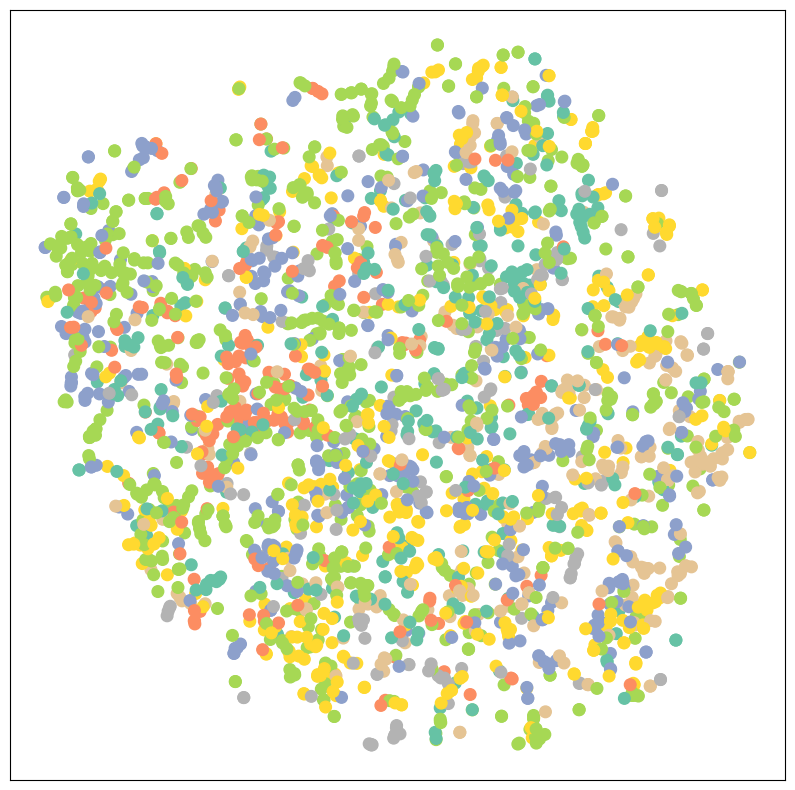

In [13]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

训练GCN模型

In [15]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc


for epoch in tqdm(range(1, 101)):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.81it/s]

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711


 61%|██████    | 61/100 [00:00<00:00, 150.51it/s]

Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258
Epoch: 041, Loss: 1.3030
Epoch: 042, Loss: 1.3119
Epoch: 043, Loss: 1.2519
Epoch: 044, Loss: 1.2530
Epoch: 045, Loss: 1.2492
Epoch: 046, Loss: 1.2205
Epoch: 047, Loss: 1.2037
Epoch: 048, Loss: 1.1571
Epoch: 049, Loss: 1.1700
Epoch: 050, Loss: 1.1296
Epoch: 051, Loss: 1.0860
Epoch: 052, Loss: 1.1080
Epoch: 053, Loss: 1.0564
Epoch: 054, Loss: 1.0157
Epoch: 055, Loss: 1.0362
Epoch: 056, Loss: 1.0328
Epoch: 057, Loss: 1.0058
Epoch: 058, Loss: 0.9865
Epoch: 059, Loss: 0.9667
Epoch: 060, Loss: 0.9741
Epoch: 061, Loss: 0.9769


 93%|█████████▎| 93/100 [00:00<00:00, 153.35it/s]

Epoch: 062, Loss: 0.9122
Epoch: 063, Loss: 0.8993
Epoch: 064, Loss: 0.8769
Epoch: 065, Loss: 0.8575
Epoch: 066, Loss: 0.8897
Epoch: 067, Loss: 0.8312
Epoch: 068, Loss: 0.8262
Epoch: 069, Loss: 0.8511
Epoch: 070, Loss: 0.7711
Epoch: 071, Loss: 0.8012
Epoch: 072, Loss: 0.7529
Epoch: 073, Loss: 0.7525
Epoch: 074, Loss: 0.7689
Epoch: 075, Loss: 0.7553
Epoch: 076, Loss: 0.7032
Epoch: 077, Loss: 0.7326
Epoch: 078, Loss: 0.7122
Epoch: 079, Loss: 0.7090
Epoch: 080, Loss: 0.6755
Epoch: 081, Loss: 0.6666
Epoch: 082, Loss: 0.6679
Epoch: 083, Loss: 0.7037
Epoch: 084, Loss: 0.6752
Epoch: 085, Loss: 0.6266
Epoch: 086, Loss: 0.6564
Epoch: 087, Loss: 0.6266
Epoch: 088, Loss: 0.6411
Epoch: 089, Loss: 0.6226
Epoch: 090, Loss: 0.6535
Epoch: 091, Loss: 0.6317
Epoch: 092, Loss: 0.5741
Epoch: 093, Loss: 0.5572


100%|██████████| 100/100 [00:00<00:00, 149.36it/s]

Epoch: 094, Loss: 0.5710
Epoch: 095, Loss: 0.5816
Epoch: 096, Loss: 0.5745
Epoch: 097, Loss: 0.5547
Epoch: 098, Loss: 0.5989
Epoch: 099, Loss: 0.6021
Epoch: 100, Loss: 0.5799


准确率计算

In [16]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


从59%到81%，这个提升还是蛮大的；训练后的可视化展示如下：

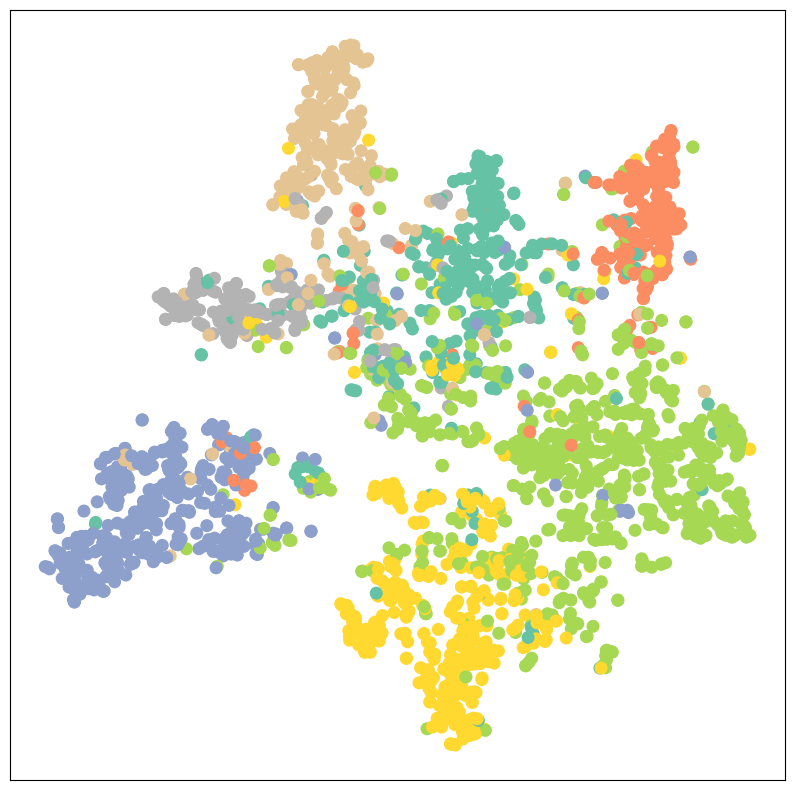

In [17]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)